<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/SP/Spectrum_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectrum of `Hg`, `He` and `H` lamps measured by spectrograph

Evgeny Kolonsky, 2024 - 2025

v.0.1.8

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd


Auxillary functions

In [95]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A = 0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength > 750:
        wavelength = 750.
    if 380 <= wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif 440 <= wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif 490 <= wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif 510 <= wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif 580 <= wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif 645 <= wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R, G, B, A)


def load_human_perception():
  url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab4/refs/heads/main/SP/CIE_sle_scotopic.csv'
  url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab4/refs/heads/main/SP/CIE_sle_photopic.csv'
  wave, factor = np.genfromtxt(url, delimiter=',').T
  perception = np.vectorize(interp1d(wave, factor, fill_value="extrapolate"))
  return perception

perception = load_human_perception()


def get_data(name):
  url = URL.format(**locals())
  waves, sample, dark = np.loadtxt(url, delimiter=';', skiprows=8, usecols=[0,1,2], unpack=True)
  counts = sample - dark
  return waves, counts



def plot_spectrum(waves, counts, peaks, mode='dark'):

  if mode == 'dark':
    pltstyle = 'dark_background'
    fill_color = 'black'
    font_color = 'white'
  else:
    pltstyle = 'default'
    fill_color = 'white'
    font_color = 'black'


  spectrum = pd.DataFrame({
      'wave_length': waves,
      'counts': counts
  })

  visible_light = (400, 720) #nm
  norm = plt.Normalize(*visible_light)
  wl = np.arange(visible_light[0], visible_light[1] + 1, 2)
  colorlist = list(zip(norm(wl), [wavelength_to_rgb(w) for w in wl]))


  spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)
  plt.style.use(pltstyle)
  fig, axs = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)

  wavelengths = spectrum['wave_length']
  intensities = spectrum['counts']
  #plt.plot(wavelengths, intensities, color='black', linewidth=1)

  y = spectrum['counts']
  X, Y = np.meshgrid(wavelengths, y)

  extent = (np.min(wavelengths), np.max(wavelengths), np.min(y), np.max(y))



  plt.imshow(X, clim=visible_light, extent=extent, cmap=spectralmap, aspect='auto')

  plt.xlabel('Wavelength (nm)')
  plt.xticks(np.arange(visible_light[0], visible_light[1]+10, 25))
  plt.ylabel('Intensity')

  plt.fill_between(wavelengths, intensities, max(intensities), color=fill_color)
  plt.plot(wavelengths, intensities, color='gray', linewidth=1)

  plt.xlim(visible_light[0], visible_light[1])
  #plt.plot(wave)

  #for peak in peaks:
  #  wave = spectrum['wave_length'].iloc[peak]
  #  if wave < visible_light[0] or wave > visible_light[1]:
  #    continue
  #  count = spectrum['counts'].iloc[peak]
  #  power = np.log(count) / np.log(10)
  #  #note = f'{wave:.0f} nm. Power {power:.1f}'
  #  note = f'{wave:.1f} nm'
  #  plt.axvline(wavelengths[peak], ymin=0, ymax=intensities[peak], color='gray',
  #              linestyle='--')
  #  plt.annotate(note, (wavelengths[peak], intensities[peak]), color=font_color)

  approximate = interp1d(wavelengths, intensities)

  for wave in peaks:
    power = float(approximate(wave))
    note = f'{wave:.0f} nm'
    plt.annotate(note, (wave, power), color=font_color, fontsize=10)
    plt.axvline(wave, ymin=0, ymax=power, color='gray',
                linestyle='--')

  plt.yscale('log')
  plt.ylim(1e1, 1e5)
  #plt.legend(loc='upper left', fancybox=True,  fontsize='x-small')
  plt.title(name.capitalize())
  plt.savefig(f'{name}.png', dpi=300)
  plt.show()

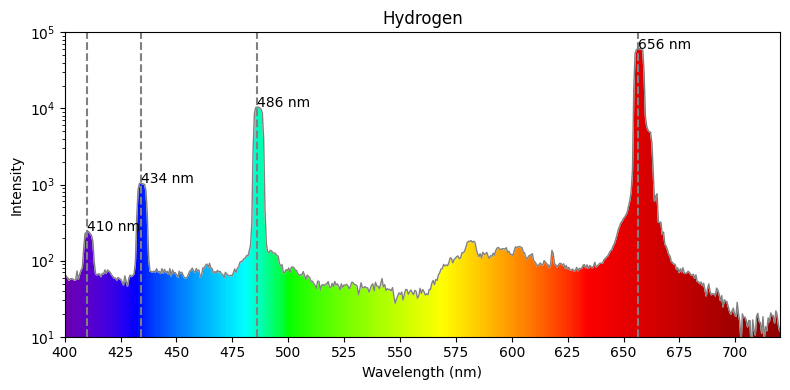

In [103]:
#URL = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_SP/{name}_1701237U1.TXT'
URL =  'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_SP/2025.09/{name}.txt'

name = 'hydrogen'
waves, counts = get_data(name)
peaks = [410.2, 434.0, 486.1, 656.3]
plot_spectrum(waves, counts, peaks, mode='light')

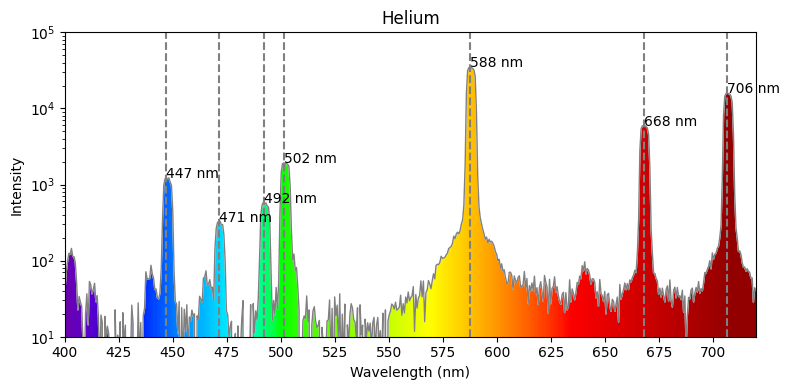

In [97]:
name = 'helium'
waves, counts = get_data(name)
peaks = [447.1, 501.5, 587.5, 667.9, 706.5, 471.3, 492.1]
plot_spectrum(waves, counts, peaks, mode='light')

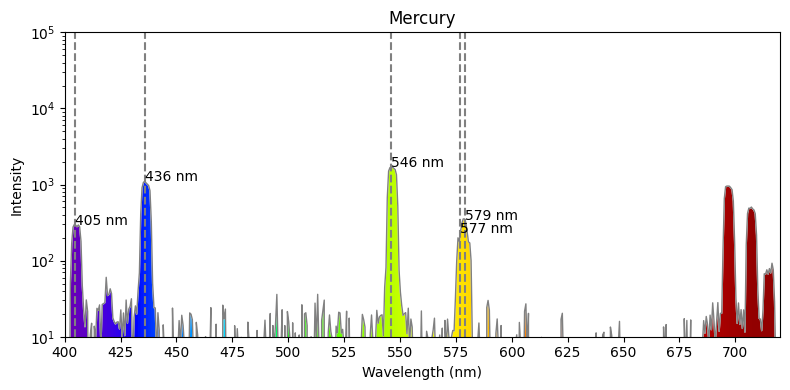

In [98]:
name = 'mercury'
waves, counts = get_data(name)
peaks = [435.8, 546.1, 577.0, 579.1, 404.7]
plot_spectrum(waves, counts, peaks, mode='light')

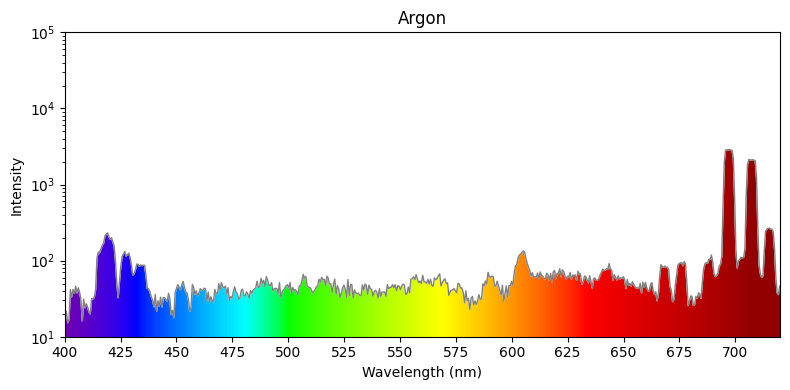

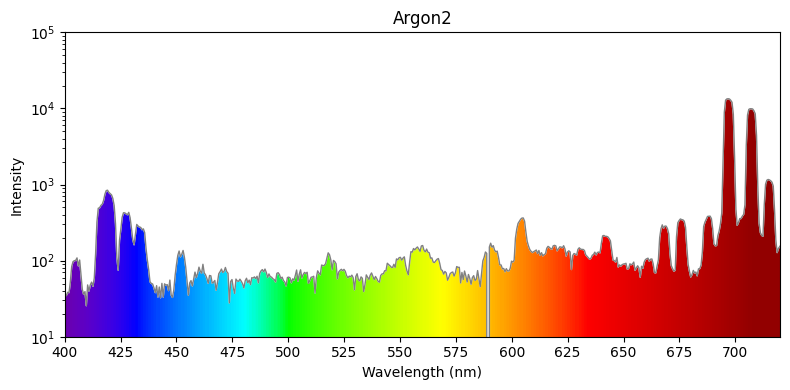

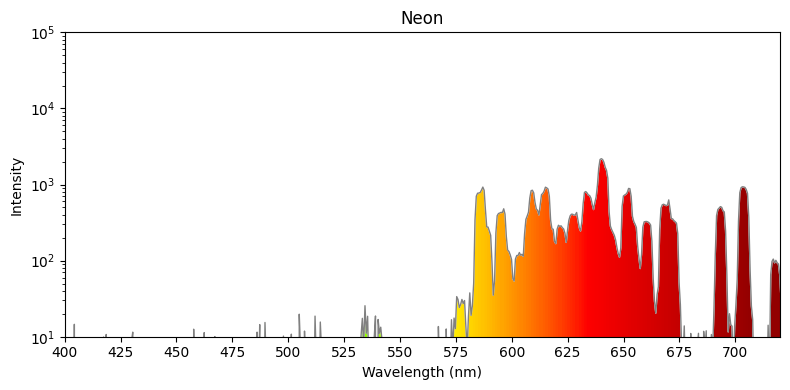

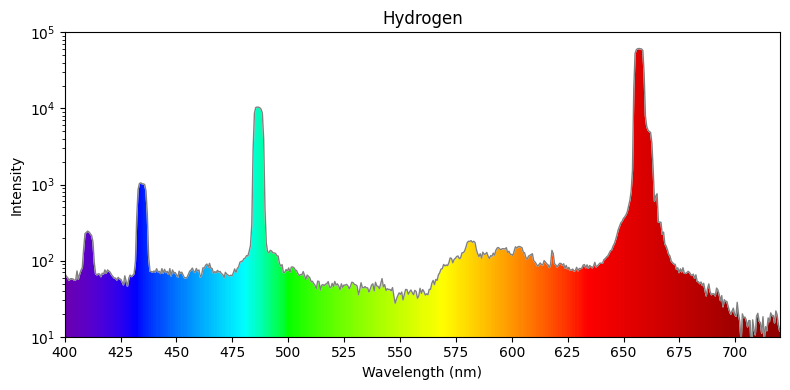

In [100]:
height=180
prominence=100

URL = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_SP/2025.09/{name}.txt'

names = ['argon', 'argon2', 'neon', 'hydrogen']

for name in names:
  waves, counts = get_data(name)
  peaks = []
  plot_spectrum(waves, counts, peaks, mode='light')